Colab implementation for

**Multi-echo MRI Reconstruction with Iteratively Refined Zero-shot Spatio-Temporal Deep Generative Prior**

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from numpy import linalg as LA
import scipy.io as sio
import matplotlib.pyplot as plt

import os

from google.colab import drive
drive.mount('/content/gdrive')

import time

# start_time = time.time()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# define functions

# CUDA usage
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Data path
data_path = '/content/gdrive/My Drive/Colab Notebooks/data/'
# data_path = './data/'

# 2D Fourier Transform (Numpy)
def ft2_np(data):
    nx,ny = data.shape[:2]
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(data),axes=(0,1))) / np.sqrt(nx*ny)

# 2D Inverse Fourier Transform (Numpy)
def ift2_np(data):
    nx,ny = data.shape[:2]
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data),axes=(0,1))) * np.sqrt(nx*ny)

# Root sum-of-squares from k-space
def isumsq(kData):
    return np.sqrt(np.sum(np.abs(ift2_np(kData))**2,axis=2))

# display an image
def showImg(img, name='',v_min=0, v_max=1.5,c_map='gray'):
    plt.axis('off')
#     plt.axis('equal')
    plt.tight_layout()
    if len(name) >0:
        plt.title(name)
    plt.imshow(np.flipud(img), cmap= c_map,vmin = v_min, vmax=v_max)
    
# display multiple images (x,y,num_image) 
def display_all(img,v_min=0, v_max=1.5):
    if img.ndim < 3:
        showImg(img)
    else:
        num_img = img.shape[2]
        num_rows = int(np.floor(np.sqrt(num_img)))
        num_cols = int(np.ceil( num_img / num_rows ))

        for k in range(num_img):
            plt.subplot(num_rows,num_cols, k+1)
            showImg(img[:,:,k],v_min=v_min,v_max=v_max)
            if k+1 == num_cols:
                plt.show()
    plt.show()



Using cuda device


**Data Load**

Image Dimensions:  206 176 32 5
Gold Standard


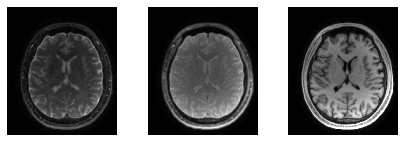

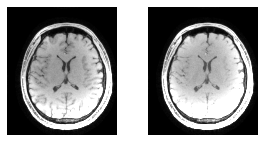

In [3]:
# Coil sensitivity
coil_sens = sio.loadmat(data_path + 'QALAS_data.mat')['coil_sens']
coil_sens = coil_sens[:,:,:,None]

# Raw k-space data 
kData = sio.loadmat(data_path+'QALAS_data.mat')['kData']


# Data size (32 channels, 5 echoes)
nx, ny, nc, ne = kData.shape

print('Image Dimensions: ',nx, ny, nc, ne)


# Gold Standard (ideal) images
ideal = (coil_sens.conj()*ift2_np( kData )).sum(2) / ((abs(coil_sens)**2).sum(2)+np.finfo(float).eps);
print('Gold Standard')
display_all(abs(ideal))


acc: 16x
Sampling Masks


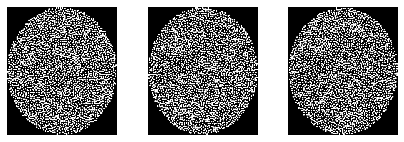

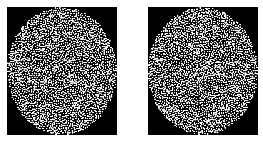

In [4]:
# Sampling mask 
kMask = sio.loadmat(data_path+'kMask12x.mat')['kMask']

acc = np.prod(kMask.shape) / kMask.sum()
acc = int(np.round(acc))
print('acc: ' + str(acc) + 'x')


mask = torch.tensor(kMask.transpose(2,3,0,1))[None,...,None].to(device)

print('Sampling Masks')
display_all(kMask[:,:,0,:],v_max = 0.1)

In [5]:
# transform to torch data format
coilc = torch.tensor(coil_sens.transpose(2,3,0,1),dtype = torch.cfloat).to(device)
datc = torch.tensor((kData*kMask).transpose(2,3,0,1),dtype=torch.cfloat)[None,:,:,:,:].to(device)
maskc = torch.tensor(kMask.transpose(2,3,0,1))[None,...].to(device)

# 2D Fourier (torch)
def ft2c(x):
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(x), dim = (-1,-2), norm = "ortho"))

# 2D Inverse Fourier (torch)
def ift2c(x):
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(x), dim = (-1,-2), norm = "ortho"))


# Forward model
def Ac(x):
    return maskc * ft2c(coilc * x[:,None,...])

# Its Hermitian
def Ahc(x):
    return (torch.conj(coilc)*ift2c(maskc*x)).sum(1)


# Inner product
def inner_c(x,y):
    return (torch.conj(x) * y).sum(list(range(1,x.dim())) )

# MSE Loss
MSE = nn.MSELoss()

# MSE for complex tensors
def MSEc(x, y):
    return MSE(torch.view_as_real(x), torch.view_as_real(y))

CG-SENSE (initial recon baseline)

iter 0 , residue 8.770937
iter 10 , residue 0.41313204
iter 20 , residue 0.13229579
iter 30 , residue 0.06367178
iter 40 , residue 0.03547466
CG-SENSE results (Naive Recon)


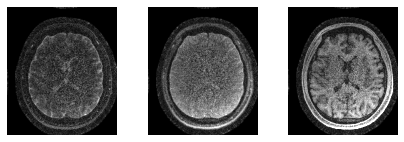

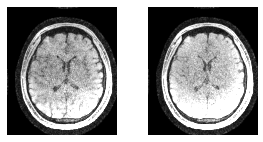

In [6]:
# CG-SENSE 

x = Ahc(datc).to(device) 


r = Ahc(datc) - Ahc(Ac(x))
p = r
rsold = torch.norm(r, 'fro') **2
# rsold = inner_c(r,r)


for it in range(50):
    z = Ahc(Ac(p))
    alpha = rsold / inner_c(p, z)
    x = x + alpha * p
    r = r - alpha * z
    rsnew = torch.norm(r, 'fro')**2

    if (it) % 10 == 0:
        print('iter', it, ', residue',np.sqrt(rsnew.cpu().numpy())) 

    if torch.sqrt(rsnew) < 1e-6:
        break
    p = r + (rsnew / rsold) * p
    rsold = rsnew

recon = x.squeeze().cpu().numpy().transpose(1,2,0)
sense = recon



print('CG-SENSE results (Naive Recon)')
display_all(abs(recon))


**Proposed Generative Network Architecture**

In [7]:
# Define generative network 
class GenNet(nn.Module):
    def __init__(self, in_channels=10, out_channels=10):
        super(GenNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer2 = nn.Sequential(
            nn.Conv2d(48, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer3 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer4 = nn.Sequential(
            nn.Conv2d(96 , 64, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1, bias=False))
            
        # Initialize weights
        self._init_weights()


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                # m.bias.data.zero_()


    def forward(self, x):
        upsample5 = self.layer1(x)
        upsample4 = self.layer2(upsample5)
        upsample3 = self.layer3(upsample4)
        upsample2 = self.layer3(upsample3)
        upsample1 = self.layer3(upsample2)
        upsample0 = self.layer4(upsample1)
        return upsample0[:,:,(256 - nx)//2:-((256 - nx)//2 + nx%2),(256 - ny)//2:-((256 - ny)//2+ny%2)]  # crop to fit the image size

**Run Generative Prior** 

In [8]:
# Run Generative Network
def run_GenNet(model,input,cur_recon, iterations = 5001,lr=1e-3):
        
    target = torch.view_as_real(torch.tensor(cur_recon,dtype = torch.cfloat))
    target = torch.cat((target[...,0],target[...,1]),dim=-1).permute(2,0,1)[None].to(device)

    x = input.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # optimizer = optim.Adam(model.parameters(), lr=lr)

    for k in range(iterations):
        optimizer.zero_grad()

        a = model(x)
        loss = MSE(a, target)
        
        if k%1000 == 0:
            print('     iter',k,', loss: ' + str(loss.cpu().detach().numpy()))

        loss.backward()
        optimizer.step()


    ti = a[0].detach().permute(1,2,0).cpu().numpy()
    tmp= ti[...,:5] + 1j*ti[...,5:]
    rec = torch.tensor(tmp).permute(2,0,1)[None].cuda()

    return rec, loss.cpu().detach().numpy()



**Image Reconstruction with generated prior**

In [9]:
# Run Reconstruction using generative prior
def SENSE_reg(rec=0, iter=50, lmbd=1e-1 ):

    x = Ahc(datc).to(device) 

    r = (Ahc(datc)+lmbd*rec) - (Ahc(Ac(x)) + lmbd*(x))
    p = r
    rsold = torch.norm(r, 'fro') **2

    for it in range(iter):
        z = Ahc(Ac(p)) + lmbd*(p)
        alpha = rsold / inner_c(p, z)
        x = x + alpha * p
        r = r - alpha * z
        rsnew = torch.norm(r, 'fro')**2

        if torch.sqrt(rsnew) < 1e-6:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew

    recon = x.squeeze().cpu().numpy().transpose(1,2,0)

    display_all(abs(recon))

    return recon


**Automatic Hyperparameter Selection**
(Number of iterations for Generative network training)

In [10]:
# hyperparameter tuning (# iterations for GenNet training)

def hyperparam_selection(test_img, num_rep=5, train_val_ratio = 0.6, learning_rate = 1e-3):
    total_val_err = 0.

    max_epoch = 3001    # Maximum number of epochs for testing
    step = 1000          # Discretization of epochs
    iter_candidates = np.arange(0,max_epoch,step) + 1
    print('Iteration # Candidates',iter_candidates)


    for m in range(num_rep):
        model = GenNet(in_channels=in_ch, out_channels=2*ne).to(device)
        input = torch.rand(1,in_ch,8,8)

        rand_vals = np.random.rand(nx,ny,ne)
        train_mask = rand_vals < train_val_ratio
        val_mask = ~train_mask


        target = torch.view_as_real(torch.tensor(test_img * train_mask,dtype = torch.cfloat))
        target = torch.cat((target[...,0],target[...,1]),dim=-1).permute(2,0,1)[None].to(device)
        tmask = torch.tensor(train_mask)
        tmask = torch.cat((tmask,tmask),dim=-1).permute(2,0,1)[None].to(device)
        x = input.to(device)

        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        val_errs = []  # validation errors


        for k in range(max_epoch):
            optimizer.zero_grad()
            a = model(x)
            loss = MSE(a*tmask, target)

            if k%step == 0:
                # print('Rep', m, 'Epoch',k, 'loss: ' + str(loss.cpu().detach().numpy()))
                ti = a[0].detach().permute(1,2,0).cpu().numpy()
                tmp= ti[...,:ne] + 1j*ti[...,ne:]
                val_err = LA.norm( (test_img - tmp) * val_mask )
                val_errs.append(val_err)
                # print('Rep', m, 'Epoch',k, "Val error", val_err)

            loss.backward()
            optimizer.step()        
        total_val_err += np.array(val_errs)
        print('Rep',m, 'Validation Error',val_errs)

    print('Done. Total Validation Error',total_val_err)
    min_idx = np.argmin(total_val_err)

    plt.plot(iter_candidates, total_val_err)
    plt.xlabel('Iterations')
    plt.ylabel('Validation Error') 
    return iter_candidates[min_idx] 



**Initialization**

Initial Recon (SENSE)


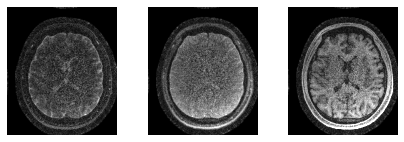

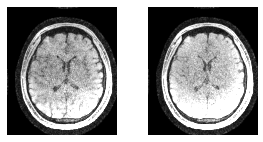

In [11]:
# Initialize Image (SENSE)
print('Initial Recon (SENSE)')
cur_recon = SENSE_reg(lmbd = 0)

In [12]:
# Initialize GenNets  
in_ch = 24      # num input channels
num_models = 3  # num GenNets (for ensemble average)

models = []
inputs = []
for k in range(num_models):
    models.append(GenNet(in_channels=in_ch, out_channels=2*ne).to(device))
    inputs.append(torch.rand(1,in_ch,8,8))


**Hyperparameter Selection (Automatic / Manual)**

Iteration # Candidates [   1 1001 2001 3001]
Rep 0 Validation Error [211.24448, 62.77214, 72.248665, 83.432144]
Rep 1 Validation Error [201.5589, 65.00354, 78.91395, 86.37416]
Rep 2 Validation Error [198.13676, 65.894485, 79.67629, 89.703575]
Rep 3 Validation Error [203.17162, 61.32167, 64.68672, 77.09094]
Rep 4 Validation Error [195.78532, 62.305984, 71.00458, 81.40206]
Done. Total Validation Error [1009.8971   317.29782  366.5302   418.0029 ]
Selected iteration number:  1001


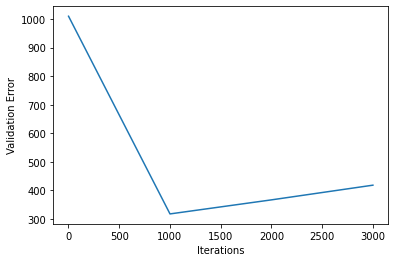

In [13]:
# Hyperparameter tuning using initial image  
# (AdamW iterations for Generative Network training)

# optimized_iter = 1001                                           # Manual 
optimized_iter = hyperparam_selection(test_img = cur_recon)   # Automatic

print('Selected iteration number: ',optimized_iter)

In [14]:
# outlier detection based on median absolute deviation (MAD)
# Andrews et. al., (1972). Robust Estimates of Location: Survey and Advances, Princeton, NJ: Princeton University Press.

def reject_outliers(data, m = 2., M = 100.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = (data - np.median(data))/mdev if mdev else 0.       # only rejects high loss values while keeping low loss values

    # s = d/mdev if mdev else 0.
    # return data[s<m]

    # print(s)
    return s<m, s>M


**Proposed Reconstruction**

EPOCH:  1
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.2699662
     iter 1000 , loss: 0.019377884
  GenNet 1 training
     iter 0 , loss: 0.26455843
     iter 1000 , loss: 0.017455248
  GenNet 2 training
     iter 0 , loss: 0.28361157
     iter 1000 , loss: 0.01591232
Image Reconstruction


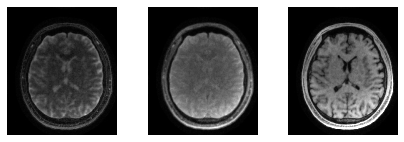

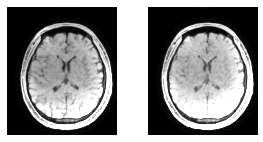

EPOCH:  2
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.002626813
     iter 1000 , loss: 0.0033295895
  GenNet 1 training
     iter 0 , loss: 0.0022508136
     iter 1000 , loss: 0.00126959
  GenNet 2 training
     iter 0 , loss: 0.002206928
     iter 1000 , loss: 0.001213541
Image Reconstruction


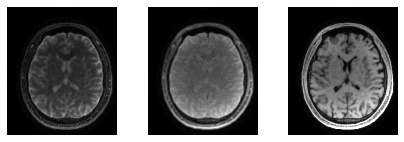

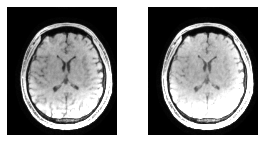

EPOCH:  3
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.0034805357
     iter 1000 , loss: 0.0024191812
  GenNet 1 training
     iter 0 , loss: 0.00096413004
     iter 1000 , loss: 0.003192858
  GenNet 2 training
     iter 0 , loss: 0.00091610174
     iter 1000 , loss: 0.00066848984
Image Reconstruction


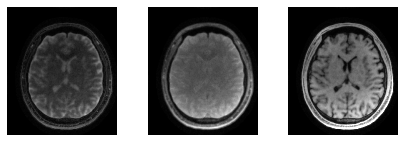

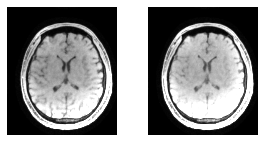

EPOCH:  4
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.0018618457
     iter 1000 , loss: 0.0012041671
  GenNet 1 training
     iter 0 , loss: 0.003063212
     iter 1000 , loss: 0.00088527
  GenNet 2 training
     iter 0 , loss: 0.00082863
     iter 1000 , loss: 0.00055448443
Image Reconstruction


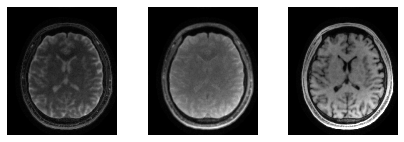

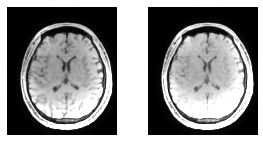

EPOCH:  5
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.001050331
     iter 1000 , loss: 0.0010879886
  GenNet 1 training
     iter 0 , loss: 0.00088768615
     iter 1000 , loss: 0.0014601751
  GenNet 2 training
     iter 0 , loss: 0.0005898616
     iter 1000 , loss: 0.0004896621
Image Reconstruction


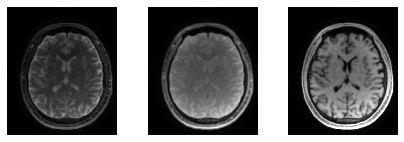

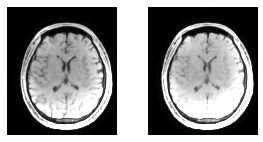

EPOCH:  6
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.0012532333
     iter 1000 , loss: 0.001272252
  GenNet 1 training
     iter 0 , loss: 0.0014164578
     iter 1000 , loss: 0.0022306736
  GenNet 2 training
     iter 0 , loss: 0.00058837194
     iter 1000 , loss: 0.0008822094
Image Reconstruction


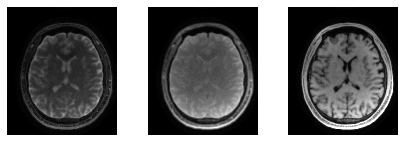

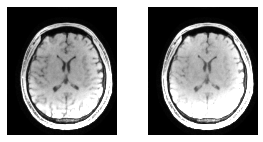

EPOCH:  7
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.0011001588
     iter 1000 , loss: 0.0006809928
  GenNet 1 training
     iter 0 , loss: 0.0021196965
     iter 1000 , loss: 0.0048957434
  GenNet 2 training
     iter 0 , loss: 0.00081052183
     iter 1000 , loss: 0.0005610222
Image Reconstruction


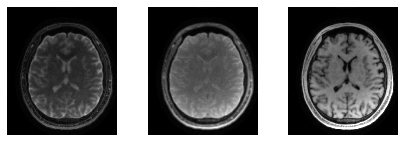

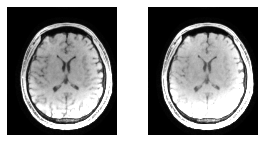

EPOCH:  8
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.00073230505
     iter 1000 , loss: 0.0006051166
  GenNet 1 training
     iter 0 , loss: 0.005311229
     iter 1000 , loss: 0.008690198
  GenNet 2 training
     iter 0 , loss: 0.0006419631
     iter 1000 , loss: 0.00045628476
Image Reconstruction


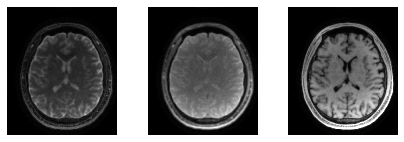

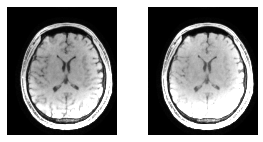

EPOCH:  9
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.0006330322
     iter 1000 , loss: 0.0008754618
  GenNet 1 training
     iter 0 , loss: 0.00908524
     iter 1000 , loss: 0.0043232813
  GenNet 2 training
     iter 0 , loss: 0.00048172867
     iter 1000 , loss: 0.00048970897
Image Reconstruction


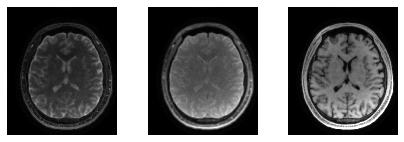

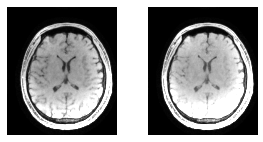

EPOCH:  10
Training Generative Networks
  GenNet 0 training
     iter 0 , loss: 0.0013961863
     iter 1000 , loss: 0.00047374784
  GenNet 1 training
     iter 0 , loss: 0.0046690973
     iter 1000 , loss: 0.0022886756
  GenNet 2 training
     iter 0 , loss: 0.00068123307
     iter 1000 , loss: 0.00037125012
Image Reconstruction


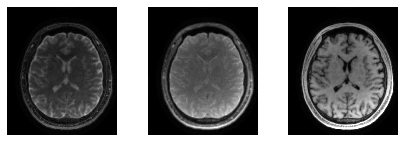

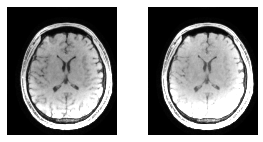

Recon Finish


In [15]:
learning_rate = 1e-3
prev_recon = cur_recon
gen_img = torch.zeros((1,ne,nx,ny,num_models), dtype=torch.cfloat).to(device)
loss_vals = np.zeros(num_models)


for epoch in range(15):
    print("EPOCH: ", epoch+1)
    print("Training Generative Networks")

    # Prior Generation: Ensemble average 
    prior_img = 0.0
    for k in range(num_models):
        print("  GenNet",k,"training")
        gen_img[...,k], loss_vals[k] = run_GenNet(models[k],inputs[k],cur_recon, iterations = optimized_iter,lr = learning_rate)

    # Outlier detection
    valid_idx, extreme_idx = reject_outliers(loss_vals)
    
    # Ensemble average after removing outlier
    prior_img = gen_img[...,valid_idx].mean(-1)

    # Re-initialize the network for extreme outliers (diverged networks) 
    for k in np.arange(num_models):
        if extreme_idx[k]:
            print("Reset diverged networks: GenNet",k)
            models[k] = GenNet(in_channels=in_ch, out_channels=2*ne).to(device)
            inputs[k] = torch.rand(1,in_ch,8,8)

    print("Image Reconstruction")
    cur_recon = SENSE_reg(prior_img)


    # Stopping criteria
    if LA.norm(prev_recon - cur_recon) / LA.norm(cur_recon) < 1e-2:
        print("Recon Finish")
        break

    prev_recon = cur_recon

**Displaying the Results**

Proposed Reconstruction


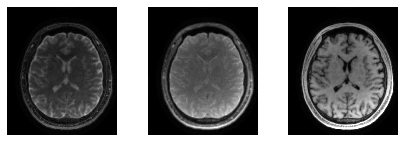

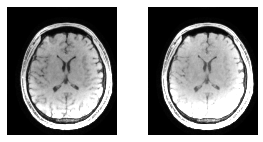

In [16]:
print("Proposed Reconstruction")
display_all(abs(cur_recon))

# print("Recontime: ", (time.time() - start_time) , 's')
